# jrnmm

[![Project Status](http://www.repostatus.org/badges/latest/concept.svg)](http://www.repostatus.org/#concept)
[![ci](https://github.com/dirmeier/jrnmm/workflows/ci/badge.svg)](https://github.com/dirmeier/jrnmm/actions?query=workflow%3Aci)

## About

This package implements a pure Python/JAX port of the Jansen-Rit neural mass model (JRNMM) from [sdbmpABC](https://github.com/massimilianotamborrino/sdbmpABC). The implementation is vectorized, so should be fairly fast in comparison.

## Example use

You can use the package to simulate the readout of the JRNMM like this:

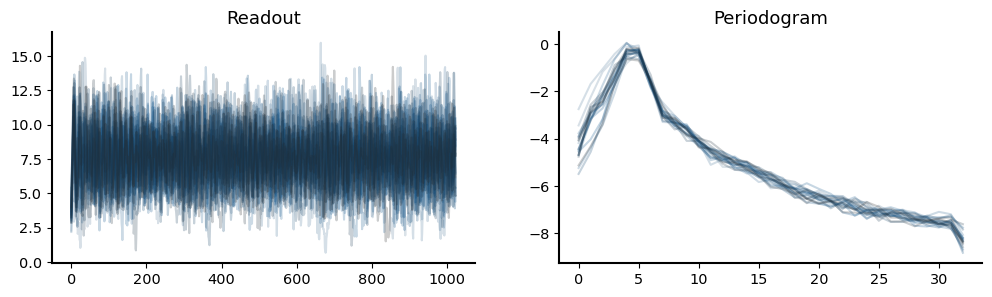

In [1]:
%matplotlib inline
import fybdthemes
import matplotlib.pyplot as plt

from jax import numpy as jnp
from jax import random as jr
from jax.scipy.signal import welch
from jrnmm import simulate

fybdthemes.set_theme()

# this samples 20 trajectories of length 8 / (1 / 128)
# each with initial condition [0.08, 18, 15, -0.5, 0, 0]
# and the same C, mu, sigma and gains
n = 20
C, mu, sigma, gain = 135, 220, 2000, 0.0
y = simulate(
    jr.PRNGKey(1),
    dt=1 / 128,
    t_end=8,
    initial_states=jnp.array([0.08, 18, 15, -0.5, 0, 0]),
    Cs=jnp.full(n, C),
    mus=jnp.full(n, mu),
    sigmas=jnp.full(n, sigma),
    gains=jnp.full(n, gain),
)
f, s = welch(y, fs=128, axis=1, nperseg=64)

_, axes = plt.subplots(figsize=(12, 3), ncols=2)
colors = fybdthemes.discrete_sequential_colors(n)
for i in range(20):
    axes[0].plot(y[i, :], color=colors[i], alpha=0.23)
    axes[1].plot(jnp.log(s[i, :]), color=colors[i], alpha=0.23)
axes[0].set_title("Readout", fontsize=13)
axes[1].set_title("Periodogram", fontsize=13)
plt.show()

Compare this to the sdbmpABC solution:

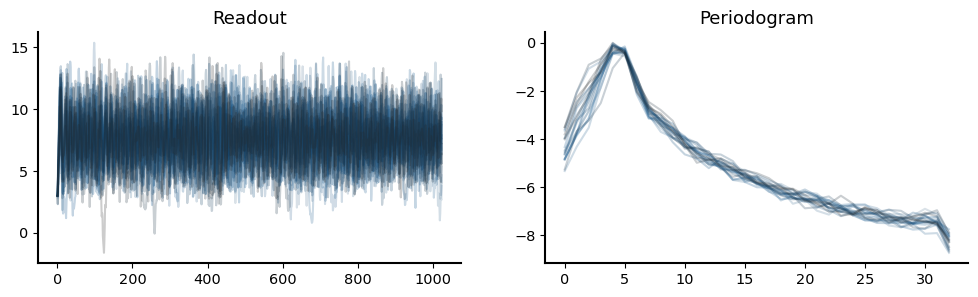

In [2]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
sdbmp = importr("sdbmsABC")

rset_seed = robjects.r["set.seed"]
rchol = robjects.r["chol"]
rt = robjects.r["t"]

_, axes = plt.subplots(figsize=(12, 3), ncols=2)
for i in range(20):
    dt = 1/128
    y0 = robjects.FloatVector(list([0.08, 18, 15, -0.5, 0, 0]))
    grid = robjects.FloatVector(list(jnp.arange(0, 8.0 + dt, dt)))
    dm = sdbmp.exp_matJR(dt, 100, 50)                
    cm = rt(
        rchol(sdbmp.cov_matJR(dt, robjects.FloatVector([0, 0, 0, 0.01, sigma, 1.0]), 100, 50))
    )    
    y = jnp.array(
        sdbmp.Splitting_JRNMM_output_Cpp(
            dt, y0, grid, dm, cm, mu, C, 3.25, 22, 100, 50, 6, 0.56, 5.0
        )
    ) 
    f, s = welch(y, fs=128, nperseg=64)
    axes[0].plot(y, color=colors[i], alpha=0.23)
    axes[1].plot(jnp.log(s), color=colors[i], alpha=0.23)
axes[0].set_title("Readout", fontsize=13)
axes[1].set_title("Periodogram", fontsize=13)
plt.show()

Some timings:|

In [3]:
from timeit import default_timer as timer

n_iter = 1_000

timings_r = []
for i in range(10):
    start = timer()
    for i in range(n_iter):
        y = jnp.array(
            sdbmp.Splitting_JRNMM_output_Cpp(
                dt, y0, grid, dm, cm, mu, C, 3.25, 22, 100, 50, 6, 0.56, 5.0
            )
        )
    end = timer() - start
    timings_r.append(end)

timings_jax = []
for i in range(10):
    start = timer()
    y = simulate(
        jr.PRNGKey(1),
        dt=1 / 128,
        t_end=8,
        initial_states=jnp.array([0.08, 18, 15, -0.5, 0, 0]),
        Cs=jnp.full(n_iter, C),
        mus=jnp.full(n_iter, mu),
        sigmas=jnp.full(n_iter, sigma),
        gains=jnp.full(n_iter, gain),
    )
    end = timer() - start
    timings_jax.append(end)

In [4]:
print(f"Timings R/C++: {sum(timings_r) / 5}")
print(f"Timings JAX: {sum(timings_jax) / 5}")

Timings R: 7.931266916800814
Timings JAX: 1.3753599164017942


## Installation

To instal from GitHub, just call:

```bash
pip install git+https://github.com/dirmeier/jrnmm@<RELEASE>
```

where `<RELEASE>` versions can be found [here](https://github.com/dirmeier/jrnmm/releases).

## Author

Simon Dirmeier <a href="mailto:sfyrbnd @ pm me">sfyrbnd @ pm me</a>